In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers

In [ ]:
test_data = pd.read_excel('/content/drive/MyDrive/Thesis/test.xlsx')
test_data.head()


In [ ]:
def tokenize_and_prepare(text):
    tokens = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    return {'input_ids': tokens['input_ids'], 'attention_mask': tokens['attention_mask']}, text


In [ ]:
!pip install torch

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification

data = pd.read_excel('/content/drive/MyDrive/Thesis/data.xlsx')
data = data[['paragraph', '0-5']]

import string
import nltk
from nltk.corpus import stopwords
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

# Приведение к нижнему регистру
data['paragraph'] = data['paragraph'].str.lower()

# Удаление стоп-слов
stop_words = set(stopwords.words('russian'))
data['paragraph'] = data['paragraph'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

# Лемматизация
lemmatizer = WordNetLemmatizer()
data['paragraph'] = data['paragraph'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

# Удаление пунктуации и специальных символов
data['paragraph'] = data['paragraph'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

model_name = "bert-base-uncased"  # You can change this to your desired model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

def tokenize_and_prepare(row):
    text = row['paragraph']
    complexity = row['0-5']
    tokens = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    return {'input_ids': tokens['input_ids'], 'attention_mask': tokens['attention_mask']}, complexity



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1: Average Loss: 0.9284811642810253
Epoch 2: Average Loss: 0.6768670029668753
Epoch 3: Average Loss: 0.6455145152702901
Epoch 4: Average Loss: 0.6320027249978449
Epoch 5: Average Loss: 0.6294913658392434


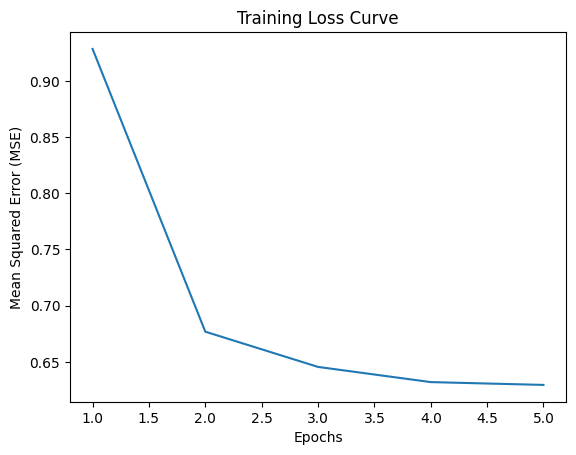

In [ ]:

tokenized_data = data.apply(tokenize_and_prepare, axis=1)

max_length = 256

input_ids_list = []
attention_mask_list = []

for item in tokenized_data:
    input_ids = item[0]['input_ids']
    attention_mask = item[0]['attention_mask']

    if input_ids.shape[1] > max_length:
        input_ids = input_ids[:, :max_length]
        attention_mask = attention_mask[:, :max_length]
    elif input_ids.shape[1] < max_length:
        padding_length = max_length - input_ids.shape[1]
        input_ids = torch.cat([input_ids, torch.zeros((1, padding_length), dtype=torch.long)], dim=1)
        attention_mask = torch.cat([attention_mask, torch.zeros((1, padding_length), dtype=torch.long)], dim=1)
    input_ids_list.append(input_ids)
    attention_mask_list.append(attention_mask)
inputs_dict = {
    'input_ids': torch.stack(input_ids_list),
    'attention_mask': torch.stack(attention_mask_list)
}
labels = torch.tensor([item[1] for item in tokenized_data], dtype=torch.float32)
input_ids_tensor = inputs_dict['input_ids']
attention_mask_tensor = inputs_dict['attention_mask']
tensor_list = [input_ids_tensor, attention_mask_tensor, labels]
dataset = TensorDataset(*tensor_list)
train_dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=1e-4)
loss_fn = torch.nn.MSELoss()
train_losses = []
for epoch in range(5):
    total_loss = 0
    for batch in dataset:
        optimizer.zero_grad()
        input_ids = batch[0]
        attention_mask = batch[1]
        output = model(input_ids, attention_mask=attention_mask)
        loss = loss_fn(output.logits.squeeze(), batch[2])
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(dataset)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch + 1}: Average Loss: {avg_loss}")

plt.plot(range(1, len(train_losses) + 1), train_losses)
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Training Loss Curve')
plt.show()


In [ ]:
test_paragraphs = test_data['paragraph']
test_labels = test_data['0-5']

test_tokenized_data = test_paragraphs.apply(tokenize_and_prepare)
test_max_length = 256

test_input_ids_list = []
test_attention_mask_list = []

for item in test_tokenized_data:
    input_ids = item[0]['input_ids']
    attention_mask = item[0]['attention_mask']

    if input_ids.shape[1] > test_max_length:
        input_ids = input_ids[:, :test_max_length]
        attention_mask = attention_mask[:, :test_max_length]
    elif input_ids.shape[1] < test_max_length:
        padding_length = test_max_length - input_ids.shape[1]
        input_ids = torch.cat([input_ids, torch.zeros((1, padding_length), dtype=torch.long)], dim=1)
        attention_mask = torch.cat([attention_mask, torch.zeros((1, padding_length), dtype=torch.long)], dim=1)

    test_input_ids_list.append(input_ids)
    test_attention_mask_list.append(attention_mask)

test_inputs_dict = {
    'input_ids': torch.stack(test_input_ids_list).squeeze(),
    'attention_mask': torch.stack(test_attention_mask_list).squeeze()
}

with torch.no_grad():
    test_output = model(**test_inputs_dict)
    test_predictions = test_output.logits.squeeze()
    test_predictions = test_predictions.mean(dim=1).squeeze()



In [ ]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test_labels, test_predictions)
print(f"Mean Squared Error on Test Data: {mse}")


In [ ]:
from sklearn.metrics import r2_score

r_squared = r2_score(test_labels, test_predictions)
print(f"R-squared: {r_squared}")


In [ ]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(test_labels, test_predictions)
print(f"Mean Absolute Error (MAE) on Test Data: {mae}")


In [ ]:
model_directory = '/content/drive/MyDrive/Thesis/best model'

model.save_pretrained(model_directory)
tokenizer.save_pretrained(model_directory)


In [ ]:
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Приведение к нижнему регистру
data['paragraph'] = data['paragraph'].str.lower()

# Удаление стоп-слов
stop_words = set(stopwords.words('english'))
data['paragraph'] = data['paragraph'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

# Лемматизация
lemmatizer = WordNetLemmatizer()
data['paragraph'] = data['paragraph'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

# Удаление пунктуации и специальных символов
data['paragraph'] = data['paragraph'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))


In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Загрузка списка стоп-слов для русского языка
stop_words = set(stopwords.words('russian'))

word_tokens = word_tokenize(text, language='russian')
filtered_text = [word for word in word_tokens if word.lower() not in stop_words]

# Преобразование обратно в текст
filtered_text = ' '.join(filtered_text)
print(filtered_text)


КОРРЕЛЯЦИЯ КЛАСС - ОЦЕНКА GPT

In [3]:
import pandas as pd

data = pd.read_excel('/content/drive/MyDrive/Thesis/data.xlsx')
data = data[['0-5', 'form']]
data.head()

,0-5,form
0,2,5
1,2,5
2,3,5
3,1,5
4,2,5


In [4]:
# вычисляем корреляцию (Спирмен)
import scipy
from scipy.stats import pearsonr
from scipy.stats import spearmanr

asses =  data['0-5']

form = data['form']

corr, p_value = spearmanr(asses, form)

In [5]:
print(f"Spearman correlation coefficient: {corr}")
print(f"P-value: {p_value}")


Spearman correlation coefficient: 0.32115709234197504
P-value: 0.00010319304143707395


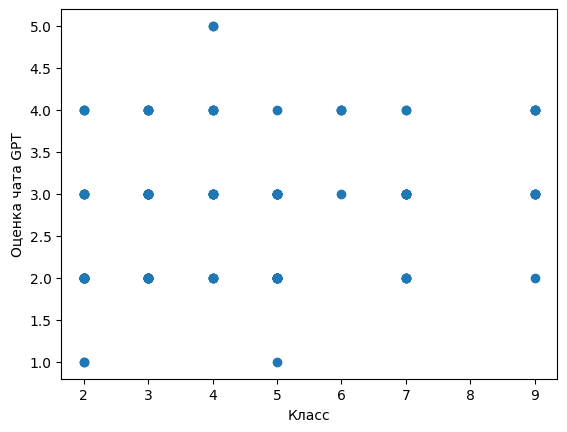

In [6]:
import matplotlib.pyplot as plt

plt.plot(form, asses, 'o')
plt.xlabel('Класс')
plt.ylabel('Оценка чата GPT')
plt.title('')
plt.show()
